In [1]:
from abc import ABC, abstractmethod
from typing import Optional, List, Type, Tuple, Dict
import math

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.axes._axes import Axes
import torch
import torch.nn as nn
import numpy as np
from torchvision import transforms
from tqdm import tqdm
from torchvision.utils import make_grid
import torch.nn.functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


The dataset I will be using is CelebFaces, which consists of images of celebrity faces. For this project, I will use approximately 60,000 images. The ultimate goal is to learn a vector field that enables the generation of images from the distribution of human celebrity faces, starting from Gaussian noise and evolving through the simulation of an ODE.

In [3]:
import os
import io
from PIL import Image
import zipfile

# Path to the zip file containing the CelebA dataset
zip_file_path = "/content/celebfaces.zip"

# Function to resize images
def resize_images(zip_file_path, target_size=(64, 64)):
    X_train = []
    # Open the ZIP file
    with zipfile.ZipFile(zip_file_path, "r") as zip_ref:
        # Loop through each file in the zip
        for file_name in zip_ref.namelist():
            if file_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                with zip_ref.open(file_name) as file:
                    # Open image and resize
                    image = Image.open(file)
                    resized_image = image.resize(target_size)
                    X_train.append(resized_image)
                    # Convert image to numpy array and append to X_train
                    # X_train.append(np.array(resized_img))
    return X_train

# Resize images and store them in X_train
images = resize_images(zip_file_path)
print("Number of resized images:", len(images))
# images = np.array(images)/ 255.0

Number of resized images: 59056


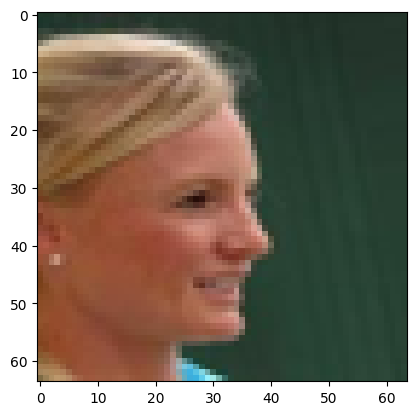

In [4]:
#An example of image in this dataset :
plt.imshow(images[3])

In this cell, I will implement everything needed, starting from the Gaussian distribution and the Gaussian probability decay paths (alpha and beta), as well as all the sampling methods required along this path. I will also define the target conditional vector field and the conditional score, although the score won't be used in this notebook since we are not relying on an SDE-based approach .

In [5]:
class Sampleable(ABC):
    """
    Distribution from which we can sample .
    """
    @abstractmethod #necessary for all subclasses
    def sample(self , num_samples : int) -> torch.Tensor :
        """
        Args:
            - num_samples: the desired number of samples
        Returns:
            - samples: shape (batch_size, ...)
        """
        pass

class GaussianIsotropic(nn.Module, Sampleable):
    """
        shape: shape of sampled data
        """
    def __init__(self, shape : List[int] ,std : float = 1.0 ) :
        super().__init__()
        self.shape = shape
        self.std = std
        self.dummy = nn.Buffer(torch.zeros(1)) #to keep the same device

    def sample(self, num_samples : int) -> torch.Tensor :
        return (self.std**2)*torch.randn(num_samples, *self.shape).to(self.dummy.device)

class LinearAlpha :
    """
    Implements alpha_t = t
    """
    def __call__(self , t : torch.Tensor) -> torch.Tensor:
        """
        Args:
            - t: time (num_samples, 1, 1, 1) -- to avoid problems with broadcasting
        Returns:
            - alpha_t (num_samples, 1, 1, 1)
        """
        return t

    def dt(self, t : torch.Tensor) :
        """
        Evaluates d/dt alpha_t.
        Args:
            - t: time (num_samples, 1, 1, 1)
        Returns:
            - d/dt alpha_t (num_samples, 1, 1, 1)
        """
        return torch.ones_like(t)

class LinearBeta :
    """
    Implements beta_t = 1 - t
    """
    def __call__(self , t : torch.Tensor) -> torch.Tensor:
        """
        Args:
            - t: time (num_samples, 1, 1, 1) -- to avoid problems with broadcasting
        Returns:
            - beta_t (num_samples, 1, 1, 1)
        """
        return 1 - t

    def dt(self, t : torch.Tensor) :
        """
        Evaluates d/dt beta_t.
        Args:
            - t: time (num_samples, 1, 1, 1)
        Returns:
            - d/dt beta_t (num_samples, 1, 1, 1)
        """
        return -torch.ones_like(t)

class GaussianConditionalProbabilityPath(nn.Module):
    def __init__(self , p_data : Sampleable ,p_simple_shape: List[int], alpha : LinearAlpha , beta : LinearBeta ) :
        super().__init__()
        self.p_simple = GaussianIsotropic(p_simple_shape)
        self.p_data = p_data
        self.alpha = alpha
        self.beta = beta

    def sample_marginal_path(self, t: torch.Tensor) -> torch.Tensor:
        """
        Samples from the marginal distribution p_t(x) = p_t(x|z) p(z)
        Args:
            - t: time (num_samples, 1, 1, 1)
        Returns:
            - x: samples from p_t(x), (num_samples, c, h, w)
        """
        num_samples = t.size(0)
        # Sample conditioning variable z ~ p(z)
        z = self.sample_conditioning_variable(num_samples) # (num_samples, c, h, w)
        # Sample conditional probability path x ~ p_t(x|z)
        x = self.sample_conditional_path(z, t) # (num_samples, c, h, w)
        return x

    def sample_conditioning_variable(self, num_samples: int) -> torch.Tensor:
        """
        Samples the conditioning variable z
        Args:
            - num_samples: the number of samples
        Returns:
            - z: (num_samples, c, h, w)
        """

        return self.p_data.sample(num_samples) #(num_samples, c, h, w)


    def sample_conditional_path(self, z: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Samples from the conditional distribution p_t(x|z)
        Args:
            - z: conditioning variable (num_samples, c, h, w)
            - t: time (num_samples, 1, 1, 1)
        Returns:
            - x: samples from p_t(x|z), (num_samples, c, h, w)
        """
        return self.alpha(t)*z + self.beta(t)*torch.randn_like(z)

    def conditional_vector_field(self, x: torch.Tensor, z: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Evaluates the conditional vector field u_t(x|z)
        Args:
            - x: position variable (num_samples, c, h, w)
            - z: conditioning variable (num_samples, c, h, w)
            - t: time (num_samples, 1, 1, 1)
        Returns:
            - conditional_vector_field: conditional vector field (num_samples, c, h, w)
        """
        alpha_t = self.alpha(t) # (num_samples, 1, 1, 1)
        beta_t = self.beta(t) # (num_samples, 1, 1, 1)
        dt_alpha_t = self.alpha.dt(t) # (num_samples, 1, 1, 1)
        dt_beta_t = self.beta.dt(t) # (num_samples, 1, 1, 1)

        return (dt_alpha_t - dt_beta_t / beta_t * alpha_t) * z + dt_beta_t / beta_t * x


    def conditional_score(self, x: torch.Tensor, z: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Evaluates the conditional score of p_t(x|z)
        Args:
            - x: position variable (num_samples, c, h, w)
            - z: conditioning variable (num_samples, c, h, w)
            - t: time (num_samples, 1, 1, 1)
        Returns:
            - conditional_score: conditional score (num_samples, c, h, w)
        """
        alpha_t = self.alpha(t)
        beta_t = self.beta(t)
        return (z * alpha_t - x) / beta_t ** 2



I will wrap the CelebFaces dataset with the Sampleable interface defined above, which will allow us to sample images following the $p_{data}$ distribution.

In [6]:
class CelebFacesSampler(nn.Module, Sampleable):
    """
    Sampleable wrapper for the MNIST dataset
    """
    def __init__(self , dataset):
        super().__init__()
        transform = transforms.Compose([
            transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
            transforms.ToTensor(),                        # Now shape: (1, H, W)
        ])


        gray_dataset = [transform(img) for img in dataset]  # Each is (1, H, W)
        self.dataset = torch.stack(gray_dataset) #  shape (N, 1, H, W)
        self.dummy = nn.Buffer(torch.zeros(1)) # for device

    def sample(self, num_samples: int) -> torch.Tensor:
        """
        Args:
            - num_samples: the desired number of samples
        Returns:
            - samples: shape (batch_size, c, h, w)
            - labels: shape (batch_size, label_dim)
        """
        if num_samples > len(self.dataset):
            raise ValueError(f"num_samples exceeds dataset size: {len(self.dataset)}")

        indices = torch.randperm(len(self.dataset))[:num_samples]
        samples = self.dataset[indices].to(self.dummy)
        return samples



The core idea behind this particular type of diffusion model is to use ODE simulation to generate new samples. That’s why we’ll use the ODE and EulerSimulator classes — they simplify the sampling process during generation.

In [7]:
class ODE(ABC):
    @abstractmethod
    def drift_coefficient(self, xt: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Returns the drift coefficient of the ODE.
        Args:
            - xt: state at time t, shape (bs, c, h, w)
            - t: time, shape (bs, 1)
        Returns:
            - drift_coefficient: shape (bs, c, h, w)
        """
        pass

class EulerSimulator:
    def __init__(self, ode: ODE):
        self.ode = ode

    def step(self, xt: torch.Tensor, t: torch.Tensor, h: torch.Tensor):
        """
        Takes one simulation step
        Args:
            - xt: state at time t, shape (bs, c, h, w)
            - t: time, shape (bs, 1, 1, 1)
            - dt: time, shape (bs, 1, 1, 1)
        Returns:
            - nxt: state at time t + dt (bs, c, h, w)
        """
        return xt + self.ode.drift_coefficient(xt,t) * h


    @torch.no_grad()
    def simulate(self, x: torch.Tensor, ts: torch.Tensor):
        """
        Simulates using the discretization gives by ts
        Args:
            - x_init: initial state, shape (bs, c, h, w)
            - ts: timesteps, shape (bs, nts, 1, 1, 1)
        Returns:
            - x_final: final state at time ts[-1], shape (bs, c, h, w)
        """
        nts = ts.shape[1]
        for t_idx in tqdm(range(nts - 1)):
            t = ts[:, t_idx]
            h = ts[:, t_idx + 1] - ts[:, t_idx]
            x = self.step(x, t, h)
        return x

    @torch.no_grad()
    def simulate_with_trajectory(self, x: torch.Tensor, ts: torch.Tensor):
        """
        Simulates using the discretization gives by ts
        Args:
            - x: initial state, shape (bs, c, h, w)
            - ts: timesteps, shape (bs, nts, 1, 1, 1)
        Returns:
            - xs: trajectory of xts over ts, shape (batch_size, nts, c, h, w)
        """
        xs = [x.clone()]
        nts = ts.shape[1]
        for t_idx in tqdm(range(nts - 1)):
            t = ts[:,t_idx]
            h = ts[:, t_idx + 1] - ts[:, t_idx]
            x = self.step(x, t, h)
            xs.append(x.clone())
        return torch.stack(xs, dim=1)



In [8]:
class ConditionalVectorField(nn.Module, ABC):
    """
    MLP-parameterization of the learned vector field u_t^theta(x)
    """

    @abstractmethod
    def forward(self, x: torch.Tensor, t: torch.Tensor):
        """
        Args:
        - x: (bs, c, h, w)
        - t: (bs, 1, 1, 1)
        Returns:
        - u_t^theta(x): (bs, c, h, w)
        """
        pass

class CFGVectorFieldODE(ODE):
    def __init__(self, net: ConditionalVectorField):
        self.net = net

    def drift_coefficient(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Args:
        - x: (bs, c, h, w)
        - t: (bs, 1, 1, 1)
        """
        vector_field = self.net(x, t)
        return vector_field


Now for the training part: we will train our vector field (net), using MSE loss between the network’s output and the conditional vector field of the Gaussian path — after sampling the time $t$, the latent variable $z$ from the $p_{data}$, and the point $x$ along the conditional path and time $t$.

In [14]:
class Trainer:
    def __init__(self, path : GaussianConditionalProbabilityPath, model: ConditionalVectorField):
        self.path = path
        self.model = model

    def get_train_loss(self, batch_size: int) -> torch.Tensor:
        # Step 1: Sample z from p_data
        z = self.path.p_data.sample(batch_size)    # (bs,c,h,w)

        # Step 2: Sample t and x
        t = torch.rand((batch_size,1,1,1)).to(z.device) # (bs,c,h,w)
        x = self.path.sample_conditional_path(z,t) # (bs,c,h,w)

        # Step 3: Regress and output loss
        u_target = self.path.conditional_vector_field(x,z,t) # (bs,c,h,w)
        u_theta = self.model(x,t) # (bs,c,h,w)

        return torch.mean( (u_target - u_theta).view(batch_size,-1).pow(2).sum(dim = -1))

    def get_optimizer(self, lr: float):
        return torch.optim.Adam(self.model.parameters(), lr=lr)

    def train(self, num_epochs: int, batch_size: int,  device: torch.device, lr: float = 1e-3) -> torch.Tensor:
        # Start
        self.model.to(device)
        opt = self.get_optimizer(lr)
        self.model.train()

        # Train loop
        pbar = tqdm(enumerate(range(num_epochs)))
        for idx, epoch in pbar:
            opt.zero_grad()
            loss = self.get_train_loss(batch_size)
            loss.backward()
            opt.step()
            pbar.set_description(f'Epoch {idx}, loss: {loss.item():.3f}')

        # Finish
        self.model.eval()


# U-Net :

In [12]:
def flatten(v):
    """
    Flatten a list of lists/tuples
    """
    return [x for y in v for x in y]



class fourier_transform(nn.Module) :
    """
    Embed time steps into a higher dimension space
    Args :
        - t_emb_dim : dimension of output embedding .
    """
    def __init__(self , t_emb_dim : int ) :
        super(fourier_transform , self).__init__()
        assert t_emb_dim % 2 == 0
        self.t_emb_dim = t_emb_dim
        self.dummy = nn.Buffer(torch.zeros(1))
    def forward( self , t : torch.Tensor) :
        """ Embed time steps into a higher dimension space
        Args :
            - ts : shape (bs,1)
        """
        half_dim = self.t_emb_dim // 2
        t_emb = np.log(10000) / (half_dim - 1)
        t_emb = torch.exp(torch.arange(half_dim) * -t_emb)
        t_emb = t_emb.to(self.dummy.device)
        t_emb = t * t_emb
        t_emb = torch.cat((torch.sin(t_emb), torch.cos(t_emb)),1)

        return t_emb # (bs, t_emb_dim)

class Upsample(nn.Module) :
    """
    This module increases the spatial resolution of a tensor (e.g., from 32×32 to 64×64).

    Args:
        n_channels: Number of channels in the input and output.
        with_conv: If True, applies a convolution after upsampling.
    """
    def __init__(self , n_channels : int, with_conv : bool = True) :
        super(Upsample,self).__init__()
        self.with_conv = with_conv
        self.n_channels = n_channels

        self.up_sample = nn.Upsample(scale_factor=2, mode='nearest')
        self.conv = nn.Conv2d( in_channels = self.n_channels , out_channels= self.n_channels, kernel_size= 3 , stride = 1 , padding= 1)
    def forward(self , x : torch.Tensor) :
        """
        Args:
        - x: (bs, c, h, w)
        """
        x = self.up_sample(x) # (bs, c, 2*h, 2*w)

        if self.with_conv :
            x = self.conv(x) # (bs, c, 2*h, 2*w)

        return x # (bs, c, 2*h, 2*w)

class Downsample(nn.Module) :
    """
    Reduces the spatial resolution of the tensor (e.g., 64×64 to 32×32).

    Args :
        - n_channels = Number of channels in the input and output
        - with_conv = True: Uses a 3×3 convolution with stride=2 to downsample while learning spatial features.
        - with_conv = False: Uses average pooling with kernel size 2.
    """
    def __init__(self, n_channels: int , with_conv : bool = True) :
        super(Downsample,self).__init__()
        self.n_channels = n_channels
        self.with_conv = with_conv
        self.conv = nn.Conv2d( in_channels = self.n_channels , out_channels = self.n_channels, kernel_size= 3 , stride = 2 , padding= 1)
        self.avgpool = nn.AvgPool2d(kernel_size=2)


    def forward(self , x) :
        """
        Args:
            - x: (bs, c, h, w)
        """
        if self.with_conv :
            x = self.conv(x) #(bs, c, h//2, w//2)
        else :
            x = self.avgpool(x) #(bs, c, h//2, w//2)

        return x    #(bs, c, h//2, w//2)

class Residual_block(nn.Module) :
    """Applies two convolutions with a residual (skip) connection and a timestep embedding.

    Args :
        - t_emb_dim: dimension of the time embedding.
        - in_channels : Number of channels in the input .
        - out_channels : Number of channels in the output.
    """
    def __init__(self , in_channels : int, out_channels : int , t_emb_dim : int ) :
        super(Residual_block, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.t_emb_dim = t_emb_dim

        self.conv_1 = nn.Conv2d( in_channels = self.in_channels , out_channels = self.out_channels , kernel_size= 3 , padding=1)
        self.conv_2 = nn.Conv2d( in_channels = self.out_channels , out_channels = self.out_channels , kernel_size= 3, padding=1)
        self.swish = nn.SiLU()

        self.Fc = nn.Linear(self.t_emb_dim , self.out_channels)

        if self.in_channels != self.out_channels : # if are different we are allowed to use conv_a
            self.conv_a = nn.Conv2d(in_channels = self.in_channels , out_channels = self.out_channels , kernel_size= 3, padding=1)

        self.g_nn_in = nn.GroupNorm(32, self.in_channels)
        self.g_nn_out = nn.GroupNorm(32, self.out_channels)



    def forward(self , x : torch.Tensor, t : torch.Tensor) :
        """
        Args:
            - x: (bs, c, h, w)
            _ t : (bs, t_emb_dim)
        """
        res =  x.clone()
        x = self.g_nn_in(self.swish(x)) # (bs, c, h, w)
        x = self.conv_1(x)    # (bs, c, h, w)

        t = self.swish(self.Fc(t)).unsqueeze(-1).unsqueeze(-1) # (bs, 1, 1 , 1)
        x =  x + t     # (bs,c, h, w)

        x = self.swish(self.g_nn_out(x)) # (bs,c, h, w)
        x = self.conv_2(x) # (bs,c, h, w)

        if self.in_channels != self.out_channels:
            res = self.conv_a(res) # (bs,c, h, w)

        x = res + x # (bs,c, h, w)
        return x # (bs,c, h, w)



class self_attn(nn.Module):
    """"
    Allows each pixel to attend to all other pixels .
    Args :
        - in_channels: Number of channels in the input .

    """
    def __init__(self , in_channels : int):
        super(self_attn, self).__init__()
        assert in_channels % 8 == 0
        self.in_channels = in_channels
        self.out_channels = in_channels //8
        self.Q_conv = nn.Conv2d( in_channels = self.in_channels , out_channels= self.out_channels , kernel_size= 1)
        self.K_conv = nn.Conv2d( in_channels = self.in_channels , out_channels= self.out_channels , kernel_size = 1)
        self.V_conv = nn.Conv2d( in_channels = self.in_channels , out_channels= self.in_channels , kernel_size = 1 )

        self.gamma =  nn.Parameter(torch.zeros(1))# learnable



    def forward(self , x : torch.Tensor) :
        """
        Args:
            - x: (bs, c, h, w)
        """
        res = x.clone()

        bs ,c, h, w = x.shape

        k = self.K_conv(x).view(bs , -1,h*w )  # (bs, c//8, h*w)
        q = self.Q_conv(x).view(bs , -1,h*w ).permute(0,2,1) # (bs, h*w,c//8)

        v =  self.V_conv(x).view(bs , -1, h*w )  # (bs, c ,h*w)


        scores = F.softmax(torch.bmm(q,k) , dim = -1).permute(0,1,2) # (bs, h*w,h*w)
        output = torch.bmm(v , scores).view(bs,c,h,w) # (bs, c , h , w)

        return self.gamma*output + res


class U_nets( nn.Module) :
    """
    Implements a U-Net, with attention components.

    """
    def __init__(self , n_channels=3, t_emb_dim=16, bilinear=True ):
        super(U_nets, self).__init__()
        self.bilinear = bilinear
        self.n_channels = n_channels
        self.t_emb_dim = t_emb_dim

        # unet channels at each layer
        self.ch_mult = (1,1,2,2,4,4)
        u_channels = [32]
        for i in range(len(self.ch_mult)):
            n = 32* self.ch_mult[i]
            for _ in range(3):
                u_channels.append(n)

        self.u_channels = u_channels
        # Time step embedding :
        self.fourier_transform_t_emb = fourier_transform(self.t_emb_dim)
        self.fc_t1 = nn.Linear(self.t_emb_dim, 4*self.t_emb_dim)
        self.fc_t2 = nn.Linear(4*self.t_emb_dim, 4*self.t_emb_dim)

        self.swish = nn.SiLU()

        # Initial conv :
        self.conv_init = nn.Conv2d(in_channels=self.n_channels , out_channels= u_channels[0], kernel_size=3 , padding=1)

        # down sampling (res + res + (attn when resolution=16) + down) * 6
        # no down layer at last

        self.down = [[] for _ in range(len(self.ch_mult))]
        indice = 0

        for i in range(len(self.ch_mult)):
            for j in range(2):
                self.down[i].append( Residual_block(self.u_channels[indice],self.u_channels[indice + 1], 4*self.t_emb_dim))
                indice += 1
                if i == 4 :
                    self.down[i].append(self_attn(self.u_channels[indice]))

            if i != len(self.ch_mult) - 1 :
                self.down[i].append(Downsample(self.u_channels[indice]))
                indice += 1

        self.down  = nn.ModuleList(flatten(self.down))


        # Middle layers :
        self.res_1 = Residual_block(self.u_channels[-1],self.u_channels[-1 ], 4*self.t_emb_dim)
        self.att_n =  self_attn(self.u_channels[-1 ])
        self.res_2 =  Residual_block(self.u_channels[-1],self.u_channels[-1 ], 4*self.t_emb_dim)


        # up_sampling :
        self.up = [[] for _ in range(len(self.ch_mult))]
        indice += 1 # len(self.ch_mult)--1

        for i in range(len(self.ch_mult)-1,-1,-1):
            for j in range(3):
                self.up[i].append( Residual_block(self.u_channels[indice]+self.u_channels[indice-1],self.u_channels[indice - 1], 4*self.t_emb_dim))
                indice -= 1
                if i == 4 :
                    self.up[i].append(self_attn(self.u_channels[indice]))

            if i != 0 :
                self.up[i].append(Upsample(self.u_channels[indice]))

            self.up[i] = self.up[i][::-1]
        self.up  = nn.ModuleList(flatten(self.up))
        assert indice == 0
        # output conv
        self.out_conv = nn.Conv2d(in_channels=self.u_channels[0], out_channels = self.n_channels, kernel_size= 1 )

    def forward( self , x : torch.Tensor , t : torch.Tensor) :
        """
        Args:
            - x: (bs, c, h, w)
            - t: (bs, 1 , 1,1)

        """

        # time :
        t = t.squeeze(-1).squeeze(-1)
        t_emb = self.fourier_transform_t_emb(t) # (bs, t_emb_dim)
        t_emb = self.swish(self.fc_t1(t_emb)) # (bs, 4*t_emb_dim)
        t_emb = self.fc_t2(t_emb) # (bs, 4*t_emb_dim)



        # init_conv
        x = self.conv_init(x) # (bs, u[0] , h , w)


        # dowsampling
        xs = [x.clone()]

        indice = 0
        for i in range(len(self.ch_mult)):
            for j in range(2):
                x = self.down[indice](x , t_emb) # (bs, u[ind+1] , h , w)
                indice += 1
                if i == 4 :
                    x = self.down[indice](x) # (bs, u[ind] , h , w)
                    indice += 1
                xs.append(x.clone())

            if i != len(self.ch_mult) - 1 :
                x = self.down[indice](x) #  (bs, u[ind] , h//2 , w//2)
                xs.append(x.clone())
                indice +=1



        # mid_layers
        x =  self.res_1(x , t_emb ) #  (bs, u[-1] , h , w)
        x = self.att_n(x)   #(bs, u[-1] , h , w)
        x = self.res_2(x , t_emb)  #(bs, u[-1] , h , w)


        # downsampling
        indice = -1 # len(self.ch_mult)-1

        for i in range(len(self.ch_mult)):
            for j in range(3):
                res = xs.pop()

                x =  torch.cat([x, res], dim=1) # (bs, u[ind-1] + u[ind] , h, w)
                x = self.up[indice](x , t_emb) # (bs, u[ind-1 ] , h, w)
                indice -= 1
                if i == 1 :
                    x = self.up[indice](x)  # (bs, u[ind] , h, w)
                    indice -= 1

            if i != len(self.ch_mult) - 1 :
                x = self.up[indice](x) # (bs, u[ind] , 2*h, 2*w)
                indice -= 1


        assert not xs

        # final conv
        x = self.out_conv(self.swish(x)) # (bs, n_channels, h , w)

        return x


Now, we will define everything and train our model. After more than 1.5 hours on a T4 GPU, we encountered some limitations. The choice of `batch_size` and `num_residual_layers` was constrained by the GPU's 15 GB memory capacity. Despite this, we didn’t achieve excellent results even after 5000 epochs.

Just to clarify, I used a grayscale transformation on all the images, so the model only learned from grayscale images with shape \( (1, 64, 64) \), which should be easier than working with RGB images.


In [15]:
# Initialize probability path
path = GaussianConditionalProbabilityPath(
    p_data = CelebFacesSampler(dataset= images),
    p_simple_shape = [1, 64,64],
    alpha = LinearAlpha(),
    beta = LinearBeta()
).to(device)

# Initialize model
unet = U_nets(n_channels= 1 ,
    t_emb_dim = 16
)

# Initialize trainer
trainer = Trainer(path = path, model = unet)

# Train
trainer.train(num_epochs = 5000, device=device, lr=1e-4, batch_size= 250) # 7000 , 250)

Epoch 4999, loss: 362.068: : 5000it [1:22:14,  1.01it/s]


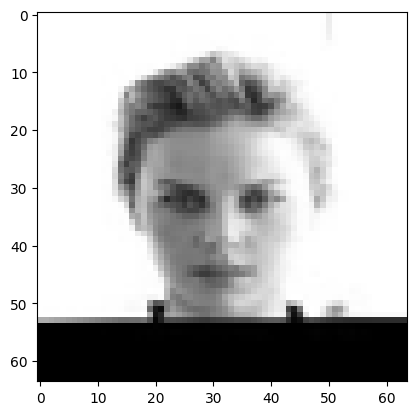

In [17]:
# An image example after gray transform :
plt.imshow(path.p_data.sample(1).squeeze(0).squeeze(0).cpu()  , cmap='gray')

100%|██████████| 99/99 [00:03<00:00, 30.89it/s]


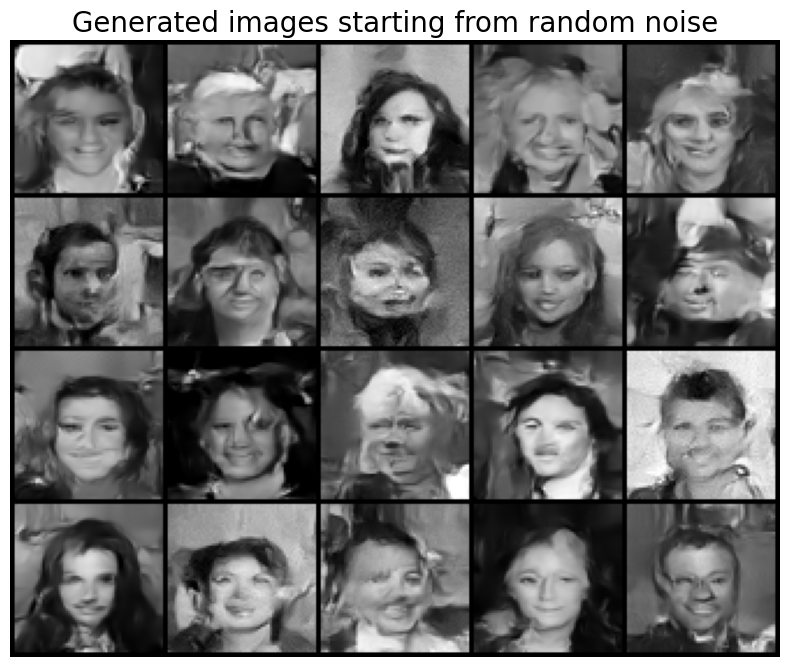

In [16]:
num_timesteps = 100


# Setup ode and simulator
ode = CFGVectorFieldODE(unet)
simulator = EulerSimulator(ode)


# Sample initial conditions
num_samples = 20
x0 = path.p_simple.sample(num_samples)  # (num_samples, 1, 32, 32)

# Simulate
ts = torch.linspace(0, 1, num_timesteps).view(1, -1, 1, 1, 1).expand(num_samples, -1, 1, 1, 1).to(device)
x1 = simulator.simulate(x0, ts)  # Shape: (num_samples, 1, 32, 32)


# Create image grid
grid = make_grid(x1, nrow=5, padding=2)

# Plot
fig, axes = plt.subplots(figsize=(8, 10))
axes.imshow(grid.permute(1, 2, 0).cpu(), cmap="gray")
axes.axis("off")
axes.set_title("Generated images starting from random noise", fontsize=20)
plt.tight_layout()
plt.show()



The model with self-attention helped us get closer to the constant C we aim to converge to. We were able to generate fairly homogeneous faces — not fully perfect, but considering the computational resources we have, I think we achieved excellent results. We can clearly see features like eyes, hair, and mouth, but those features are not well-connected; there's no smooth interpolation between them. To improve this, we may need to scale up the model and make use of more elements from the dataset — starting with the full 80k images — and possibly incorporate color information, rather than relying only on grayscale.